In [1]:
# Numerics
import qutip as qt
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from IPython.display import Image

# Tracking info of simulations
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

# Suppress DeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
#Identity
I = qt.qeye(2)
#sigma+-
sm = qt.destroy(2)
sp = qt.create(2)

ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)

#two-qubit basis
ket00 = qt.tensor([ket0,ket0])
ket01 = qt.tensor([ket0,ket1])
ket10 = qt.tensor([ket1,ket0])
ket11 = qt.tensor([ket1,ket1])

#Bell basis
psi_p = 1/np.sqrt(2)*(ket00 + ket11)
psi_m = 1/np.sqrt(2)*(ket00 - ket11)
phi_p = 1/np.sqrt(2)*(ket01 + ket10)
phi_m = 1/np.sqrt(2)*(ket01 - ket10)


#basis in DW
#1 qubit
ket0_dw = qt.tensor([ket0,ket0])
ket1_dw = qt.tensor([ket1,ket0])

#2 qubit
# ket00_dw = qt.tensor([ket0,ket0,ket0])
# ket01_dw = qt.tensor([ket1,ket1,ket0])
# ket10_dw = qt.tensor([ket1,ket0,ket0])
# ket11_dw = qt.tensor([ket0,ket1,ket0])

ket00_dw = qt.tensor([ket0,ket0])
ket01_dw = qt.tensor([ket1,ket1])
ket10_dw = qt.tensor([ket1,ket0])
ket11_dw = qt.tensor([ket0,ket1])

#Bell
psi_p_dw = 1/np.sqrt(2)*(ket00_dw + ket11_dw)
psi_m_dw = 1/np.sqrt(2)*(ket00_dw - ket11_dw)
phi_p_dw = 1/np.sqrt(2)*(ket01_dw + ket10_dw)
phi_m_dw = 1/np.sqrt(2)*(ket01_dw - ket10_dw)

In [3]:
def initialize_general_system(size, alice_register): # alice_register is already in domain wall encoding
    #initialize chain
    #check that initial state is a valid one
    if abs(1 - abs(alice_register.dag()*alice_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    alice_reg_len = len(alice_register.dims[0])
    #check that chain is long enough to do transport
    if alice_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - alice_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    initial_state = qt.tensor(alice_register, chain_state) 
    
    return initial_state


def generate_target(size, bob_register): 
    #check that final state is a valid one
    if abs(1 - abs(bob_register.dag()*bob_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    bob_reg_len = len(bob_register.dims[0])
    #check that chain is long enough to do transport
    if bob_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - bob_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    final_state = qt.tensor(chain_state, bob_register) 
    
    return final_state

    

In [4]:
def crate_domain_wall_state(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #reverse order and loop over bits
        for bit in term[::-1]:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list again and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm


def create_domain_wall_target(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #loop over bits (w/o reversing order this time)
        for bit in term:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm

In [5]:
#Define the coupling values
def J_definition(size, factor):
    strengths = np.zeros(size)
    for i in range(0,size):
        strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i))
    return strengths

#couplings in domain wall
def tn_definition(data_j):
    size = len(data_j)
    out = np.zeros(size)
    for i in range(size):
        out[i] = -data_j[i]
    return out

In [6]:
def generate_transverse_error_relative(j_couplings, fraction):
    j_errors = []
    for value in j_couplings:
        j_errors.append(value + np.random.normal(0, fraction*value , 1))
    return j_errors

def generate_transverse_error_absolute(n_spins, mean, variance):
    return np.random.normal(mean, variance , n_spins)

def generate_J_error_relative(n_spins, J, fraction):
    J_with_errors = np.random.normal(J, fraction*J , n_spins)
    J_with_errors[0] = J
    J_with_errors[-1] = J
    return J_with_errors

def generate_J_error_absolute(n_spins, J, variance):
    J_with_errors = np.random.normal(J, variance, n_spins)
    #remove error from ends because the J terms there are local Z fields, not coupling fields
    J_with_errors[0] = J
    J_with_errors[-1] = J
    return J_with_errors

def generate_z_error_absolute(n_spins, variance):
    return np.random.normal(0, variance , n_spins)



In [7]:
def Initialize_Hamiltonian(n_spins):    
# Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    #for each value of i it puts the paulis in different positions of the list, then does IxIxI...sigma_ixIxI...xI
    for i in range(n_spins):
        #list of 2x2 identity matrices
        op_list = [qt.qeye(2)] * n_spins
        #replace i-th element with sigma_x
        op_list[i] = sx
        #create matrices of 2^Nx2^N
        sx_list.append(qt.tensor(op_list))
        #do the same for sigma_y and sigma_z
        op_list[i] = sy
        sy_list.append(qt.tensor(op_list))
        op_list[i] = sz
        sz_list.append(qt.tensor(op_list))

    return sx_list, sy_list, sz_list

In [8]:
def  Hamiltonian_forward(n_spins, J_values, z_values, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in first spin
    for i in range(1, n_spins):
        Ham += -t_couplings[i-1] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i-1])

    #Virtual qubit down at end of chain
    Ham+= +(J_values[-1])*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_values[i+1]* sz_list[i]*sz_list[i+1]
    
    #Error in Z fields
    for i in range(0, n_spins):
        Ham += z_values[i]*sz_list[i]

    return Ham

def  Hamiltonian_backward(n_spins, reg_size, J_values, z_values, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in Bob's register
    for i in range(0, n_spins - reg_size):
        Ham += -t_couplings[i] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i])

    #Virtual qubit down at start of chain
    Ham += +J_values[0]*sz_list[0]
    #Ham+= +J_global*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_values[i+1]* sz_list[i]*sz_list[i+1]

    #Error in Z fields
    for i in range(0, n_spins):
        Ham += z_values[i]*sz_list[i]

    return Ham

In [9]:
def time_evolution(Ham, sigma_z_list,  initial_state, initial_time, final_time, timesteps): 
    times = np.linspace(initial_time, final_time, timesteps)
    #apply hamiltonian to initial state and don't track any observables
    options = {
    'method': 'adams'
}
    simulation_results = qt.sesolve(Ham, initial_state, times, options = options)

    return simulation_results

In [10]:
def calculate_fidelities(n_spins, state_evolution, initial_state = None, mode = "maximum"): 
    #Calculate fidelities and find maximum
    if initial_state is None:
        rho_0 = (qt.basis(2,1)*qt.basis(2,1).dag())
    else:
        rho_0 = (initial_state * initial_state.dag()).ptrace(0)
    fidelities = np.zeros((len(state_evolution), n_spins))

    for index, state in enumerate(state_evolution):
        #update if new minimum is found
        for site in range(n_spins):
            rho_n = state.ptrace(site)
            fidelities[index, site] = (qt.fidelity(rho_0, rho_n))
    if mode == "maximum":
        max_fid = [np.max(fidelities[:,i]) for i in range(n_spins)]
        max_fid_index = [np.argmax(fidelities[:,i]) for i in range(n_spins)]
    elif mode == "minimum":
        max_fid = [np.min(fidelities[:,i]) for i in range(n_spins)]
        max_fid_index = [np.argmin(fidelities[:,i]) for i in range(n_spins)]


    return fidelities, max_fid, max_fid_index



def calculate_full_fidelity(n_spins, state_evolution, target_state = None): 
    #Calculate fidelities and find maximum
    if target_state is None:
        state_list = [qt.basis(2, 0)] * (size - 1) + [psi0_1] 
        target_state = qt.tensor(state_list)
    
    #target_state = target_state * target_state.dag()

    fidelity = np.zeros(len(state_evolution.times))

    for index, state in enumerate(state_evolution.states):
         fidelity[index] = (qt.fidelity(target_state, state))

    return fidelity


def calculate_final_fidelity(n_spins, final_sate, target_state):

    fidelity = qt.fidelity(target_state, final_sate)

    return fidelity


In [11]:
def calculate_z_expectation_values(n_spins, initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin
    #calculate expectation value of sz for each spin
    magn_t = np.array([[qt.expect(op, state) for op in sigma_z_list] for state in state_evolution.states])
    #find maximums
    max_magn_i = [np.max(magn_t[:,i]) for i in range(n_spins)]
    max_magn_i_index = [np.argmax(magn_t[:,i]) for i in range(n_spins)]

    return magn_t, max_magn_i, max_magn_i_index

def calculate_final_z_expectation(n_spins, initial_state, final_state, sigma_z_list):
    magn_t = np.array([qt.expect(op, final_state) for op in sigma_z_list])

    return magn_t


In [12]:
def chain_calibration(lmd, J, N, ti, tf, Nstep):
    #If N < 10, set calibration to N. If not, set calibration to 10 or to the minimum required for the desired state
    N_calibration = N
    J_values = [J]*(N+1)
    z_values = [0]*N
    Jn = J_definition(N_calibration-1, lmd)
    tn = tn_definition(Jn)
    calibration_dictionary = {"1":1}

    input_register = crate_domain_wall_state(calibration_dictionary)
    output_register = create_domain_wall_target(calibration_dictionary)

    initial_state = initialize_general_system(N_calibration, input_register)  #generate whole chain
    final_state = generate_target(N_calibration, output_register)

    sxl, syl, szl = Initialize_Hamiltonian(N_calibration)

    # CALIBRATION
    H = Hamiltonian_forward(N_calibration, J_values, z_values, tn, sxl, syl, szl) 
    # evolve
    results_c = time_evolution(H, szl, initial_state, ti, tf, Nstep)
    # calculate fidelity and magnetization
    magnetizations_c, min_magn_c, min_magn_index_c = calculate_z_expectation_values(N_calibration, initial_state, results_c, szl)
    # Determine period of min magnetization (find time of Hamiltonian switch)
    step_of_min_magnetization = int(np.argmin(magnetizations_c[:,-1])) # max in case fidelity starts at 1
    # print(step_of_min_magnetization)
    period = (tf - ti)*step_of_min_magnetization/Nstep
    # Run reset Hamiltonian from that point to find step of max fidelity
    Jn = J_definition(N_calibration-1, lmd)
    tn = tn_definition(Jn)
    H = Hamiltonian_backward(N_calibration, 1, J_values, z_values, tn, sxl, syl, szl)
    results_b = time_evolution(H, szl, results_c.states[step_of_min_magnetization] , ti, period*1.1, int(step_of_min_magnetization*1.1))
    full_fidelity_b = calculate_full_fidelity(N_calibration, results_b, final_state)
    step_of_max_fidelity = np.argmax(full_fidelity_b)
    print(full_fidelity_b[step_of_max_fidelity])
    print(step_of_max_fidelity)


    return step_of_min_magnetization, period, step_of_max_fidelity
    


In [ ]:
def WRM_algorithm(N, lmd, J, alice_register, target_register, ti, tf, Nstep, num_experiments, transport_steps, period, reset_steps, 
                  J_err = False, J_dev = None, l_err = False, l_dev = None, z_err = False, z_dev = None):

    register_length = len(alice_register.dims[0])
    #state that we want to transfer and target final state
    initial_state = initialize_general_system(N, alice_register)  #generate whole chain
    final_state = generate_target(N, target_register)
    J_values = [J]*(N+1)

    fidelities = []
    magnetizations = []
    
    for e in range(num_experiments):
        # BACK AND FORTH ALGORITHM
        #calculate exact Jn couplings 
        exact_J_f = J_definition(N-1, lmd)
        exact_J_b = J_definition(N-register_length, lmd)

        #add error in transverse fields
        if l_err == True:
            Jnf = generate_transverse_error_relative(exact_J_f, l_dev)
            Jnb = generate_transverse_error_relative(exact_J_b, l_dev)
        else:
            Jnf = exact_J_f
            Jnb = exact_J_b

        # Add error as local Z fields
        if z_err == True:
            z_values = generate_z_error_absolute(N, z_dev)
        else:
            z_values = [0]*N

        # add errors in interaction terms
        if J_err == True:
            #N+1 to distinguish virtual qubits and couplers
            J_values = generate_J_error_relative(N+1, J, J_dev)
        else:
            J_values = [J]*(N+1)
        
        tn = tn_definition(Jnf) 
        sxl, syl, szl = Initialize_Hamiltonian(N)
        H = Hamiltonian_forward(N, J_values, z_values, tn, sxl, syl, szl)
        results_f = time_evolution(H, szl, initial_state, ti, period, transport_steps)

        #Redefine couplings
        tn = tn_definition(Jnb)
        H = Hamiltonian_backward(N, register_length, J_values, z_values, tn, sxl, syl, szl)
        results_b = time_evolution(H, szl, results_f.states[-1] , ti, period*1.5, int(transport_steps*1.5))
        final_fidelity = calculate_final_fidelity(N, results_b.states[reset_steps], final_state)
        final_magnetizations = calculate_final_z_expectation(N, initial_state, results_b.states[reset_steps], szl)
        fidelities.append(final_fidelity)
        magnetizations.append(final_magnetizations)

    return fidelities, magnetizations, transport_steps, period





In [14]:
def calculate_result_statistics(fidelity, magnetizations):
    fidelity_mean = np.mean(fidelity)
    fidelity_error = np.std(fidelity, ddof=1) / np.sqrt(len(fidelity))

    # Calculate mean and error for each index across magnetization arrays
    magnetizations_transposed = np.array(magnetizations).T  # Transpose to group by index

    magnetizations_mean = []
    magnetizations_error = []

    for i, index_values in enumerate(magnetizations_transposed):
        magnetizations_mean.append(np.mean(index_values))
        magnetizations_error.append(np.std(index_values, ddof=1) / np.sqrt(len(index_values))) 

    return fidelity_mean, fidelity_error, magnetizations_mean, magnetizations_error
    

In [15]:
N = 13
# lmd = np.linspace(0.1, 1, 10)
J = 0.5
# J = range(1,21)
lmd = 0.02272
#Evolution parameters
initial_time = 0
final_time = 150
step_number = 500
iterations = 25
 
alpha = 0
beta = 1
delta = 1
gamma = 0

# state_dictionary = {"001":0.4,"101":0.2,"111":0.6,"110":0.35}
# state_dictionary = {"1":0.8,"0":0.2}
# state_dictionary = {"0":1}
state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}

j_errors = np.linspace(0.001, 0.01, 50)
l_errors = np.linspace(0.01, 0.1, 50)
z_errors = np.linspace(0.0001, 0.004, 50)

fidelity_means = []
fidelity_errors = []
magnetizations_means = []
magnetizations_errors = []

transport_steps, period, reset_steps = chain_calibration(lmd, J, N, initial_time, final_time, step_number)
print("Calibration complete")

for value in z_errors[6:]:
    print(len(fidelity_means))
    input_register = crate_domain_wall_state(state_dictionary)
    target_state = create_domain_wall_target(state_dictionary)



    fidelity, magnetizations, period_step, period = WRM_algorithm(N, lmd, J,                                       # parameters of Hamiltonian
                                                                input_register, target_state,                      # initial and final states
                                                                initial_time, final_time, step_number,             # parameters of time evolution
                                                                iterations,                                        # number of experiments
                                                                transport_steps, period, reset_steps,               #transport time parameters      
                                                                J_err = True, J_dev = 0,                       # error parameters
                                                                l_err = True, l_dev = 0, 
                                                                z_err = True, z_dev = value)

    fidelity_mean, fidelity_error, magnetizations_mean, magnetizations_error = calculate_result_statistics(fidelity, magnetizations)
    fidelity_means.append(fidelity_mean)
    fidelity_errors.append(fidelity_error)
    magnetizations_means.append(magnetizations_mean)
    magnetizations_errors.append(magnetizations_error)



0.9909388155699546
456
Calibration complete
0


C:\Users\User\AppData\Local\Temp\ipykernel_3116\3508689649.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i] = -data_j[i]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [16]:
print(z_errors[:])
print(len(z_errors[6:]))
print(len(fidelity_means[:]))

[0.0001     0.00017959 0.00025918 0.00033878 0.00041837 0.00049796
 0.00057755 0.00065714 0.00073673 0.00081633 0.00089592 0.00097551
 0.0010551  0.00113469 0.00121429 0.00129388 0.00137347 0.00145306
 0.00153265 0.00161224 0.00169184 0.00177143 0.00185102 0.00193061
 0.0020102  0.0020898  0.00216939 0.00224898 0.00232857 0.00240816
 0.00248776 0.00256735 0.00264694 0.00272653 0.00280612 0.00288571
 0.00296531 0.0030449  0.00312449 0.00320408 0.00328367 0.00336327
 0.00344286 0.00352245 0.00360204 0.00368163 0.00376122 0.00384082
 0.00392041 0.004     ]
44
44


In [133]:
print(fidelity_means[5])

0.9869004007647387


In [ ]:
# --- Build file tag ---
state_str = '_'.join([f'{k}-{v}' for k, v in state_dictionary.items()])
file_tag = f"N{N}_J{J}_lmd{lmd}_{state_str}"

# --- Save Data to Excel ---
input_data = {
    'N': N,
    'J': J,
    'lmd': lmd,
    'initial_time': initial_time,
    'final_time': final_time,
    'step_number': step_number,
    'iterations': iterations,
    'state_dictionary': json.dumps(state_dictionary),
    'error_type': 'j_err',
    'error_range': f"{j_errors[0]} to {j_errors[-1]}",
    'num_steps': len(j_errors)
}

data_df = pd.DataFrame({
    'j_error': j_errors[6:],
    'fidelity_mean': fidelity_means,
    'fidelity_error': fidelity_errors,
    'magnetization_mean': magnetizations_means,
    'magnetization_error': magnetizations_errors
})

excel_filename = f"./data_files/data_v3/j_errors/data_sweep_{file_tag}_2.xlsx"
with pd.ExcelWriter(excel_filename, engine='openpyxl') as writer:
    pd.DataFrame([input_data]).to_excel(writer, sheet_name='inputs', index=False)
    data_df.to_excel(writer, sheet_name='sweep_results', index=False)

In [27]:
import pandas as pd
import json
from pathlib import Path

def read_simulation_data(file_path):
    """
    Reads simulation data from Excel file saved in the specified format.
    
    Args:
        file_path (str or Path): Path to the Excel file
        
    Returns:
        dict: Dictionary containing:
            - 'input_params': Dictionary of input parameters
            - 'l_errors': Array of error values
            - 'fidelity_means': Array of fidelity means
            - 'fidelity_errors': Array of fidelity errors  
            - 'magnetization_means': Array of magnetization means
            - 'magnetization_errors': Array of magnetization errors
    """
    # Read both sheets
    input_df = pd.read_excel(file_path, sheet_name='inputs')
    results_df = pd.read_excel(file_path, sheet_name='sweep_results')
    
    # Convert input parameters
    input_params = input_df.iloc[0].to_dict()
    
    # Convert JSON strings back to Python objects
    input_params['state_dictionary'] = json.loads(input_params['state_dictionary'])
    
    # Extract data arrays - note 'l_error' is singular in DataFrame
    return {
        'input_params': input_params,
        'j_errors': results_df['j_error'].values,
        'fidelity_means': results_df['fidelity_mean'].values,
        'fidelity_errors': results_df['fidelity_error'].values,
        'magnetization_means': results_df['magnetization_mean'].values,
        'magnetization_errors': results_df['magnetization_error'].values
    }

In [18]:
# Example usage
if __name__ == "__main__":
    # Example file path (replace with your actual file)
    example_file = "./data_files/data_v3/safety_files/data_sweep_N13_J0.5_lmd0.02272_1-1_lambda.xlsx"
    
    # Read the data
    simulation_data = read_simulation_data(example_file)
    
    # Access the input parameters
    params = simulation_data['input_parameters']
    print("Input Parameters:")
    print(f"N = {params['N']}")
    print(f"J = {params['J']}")
    print(f"λ = {params['lmd']}")
    print(f"State = {params['state_dictionary']}")
    print(f"Error range: {params['error_range']}")
    print(f"Number of steps: {params['num_steps']}")


    l_errors = simulation_data['l_errors']
    fidelity_means = simulation_data['fidelity_means']
    fidelity_errors = simulation_data['fidelity_errors']

KeyError: 'input_parameters'

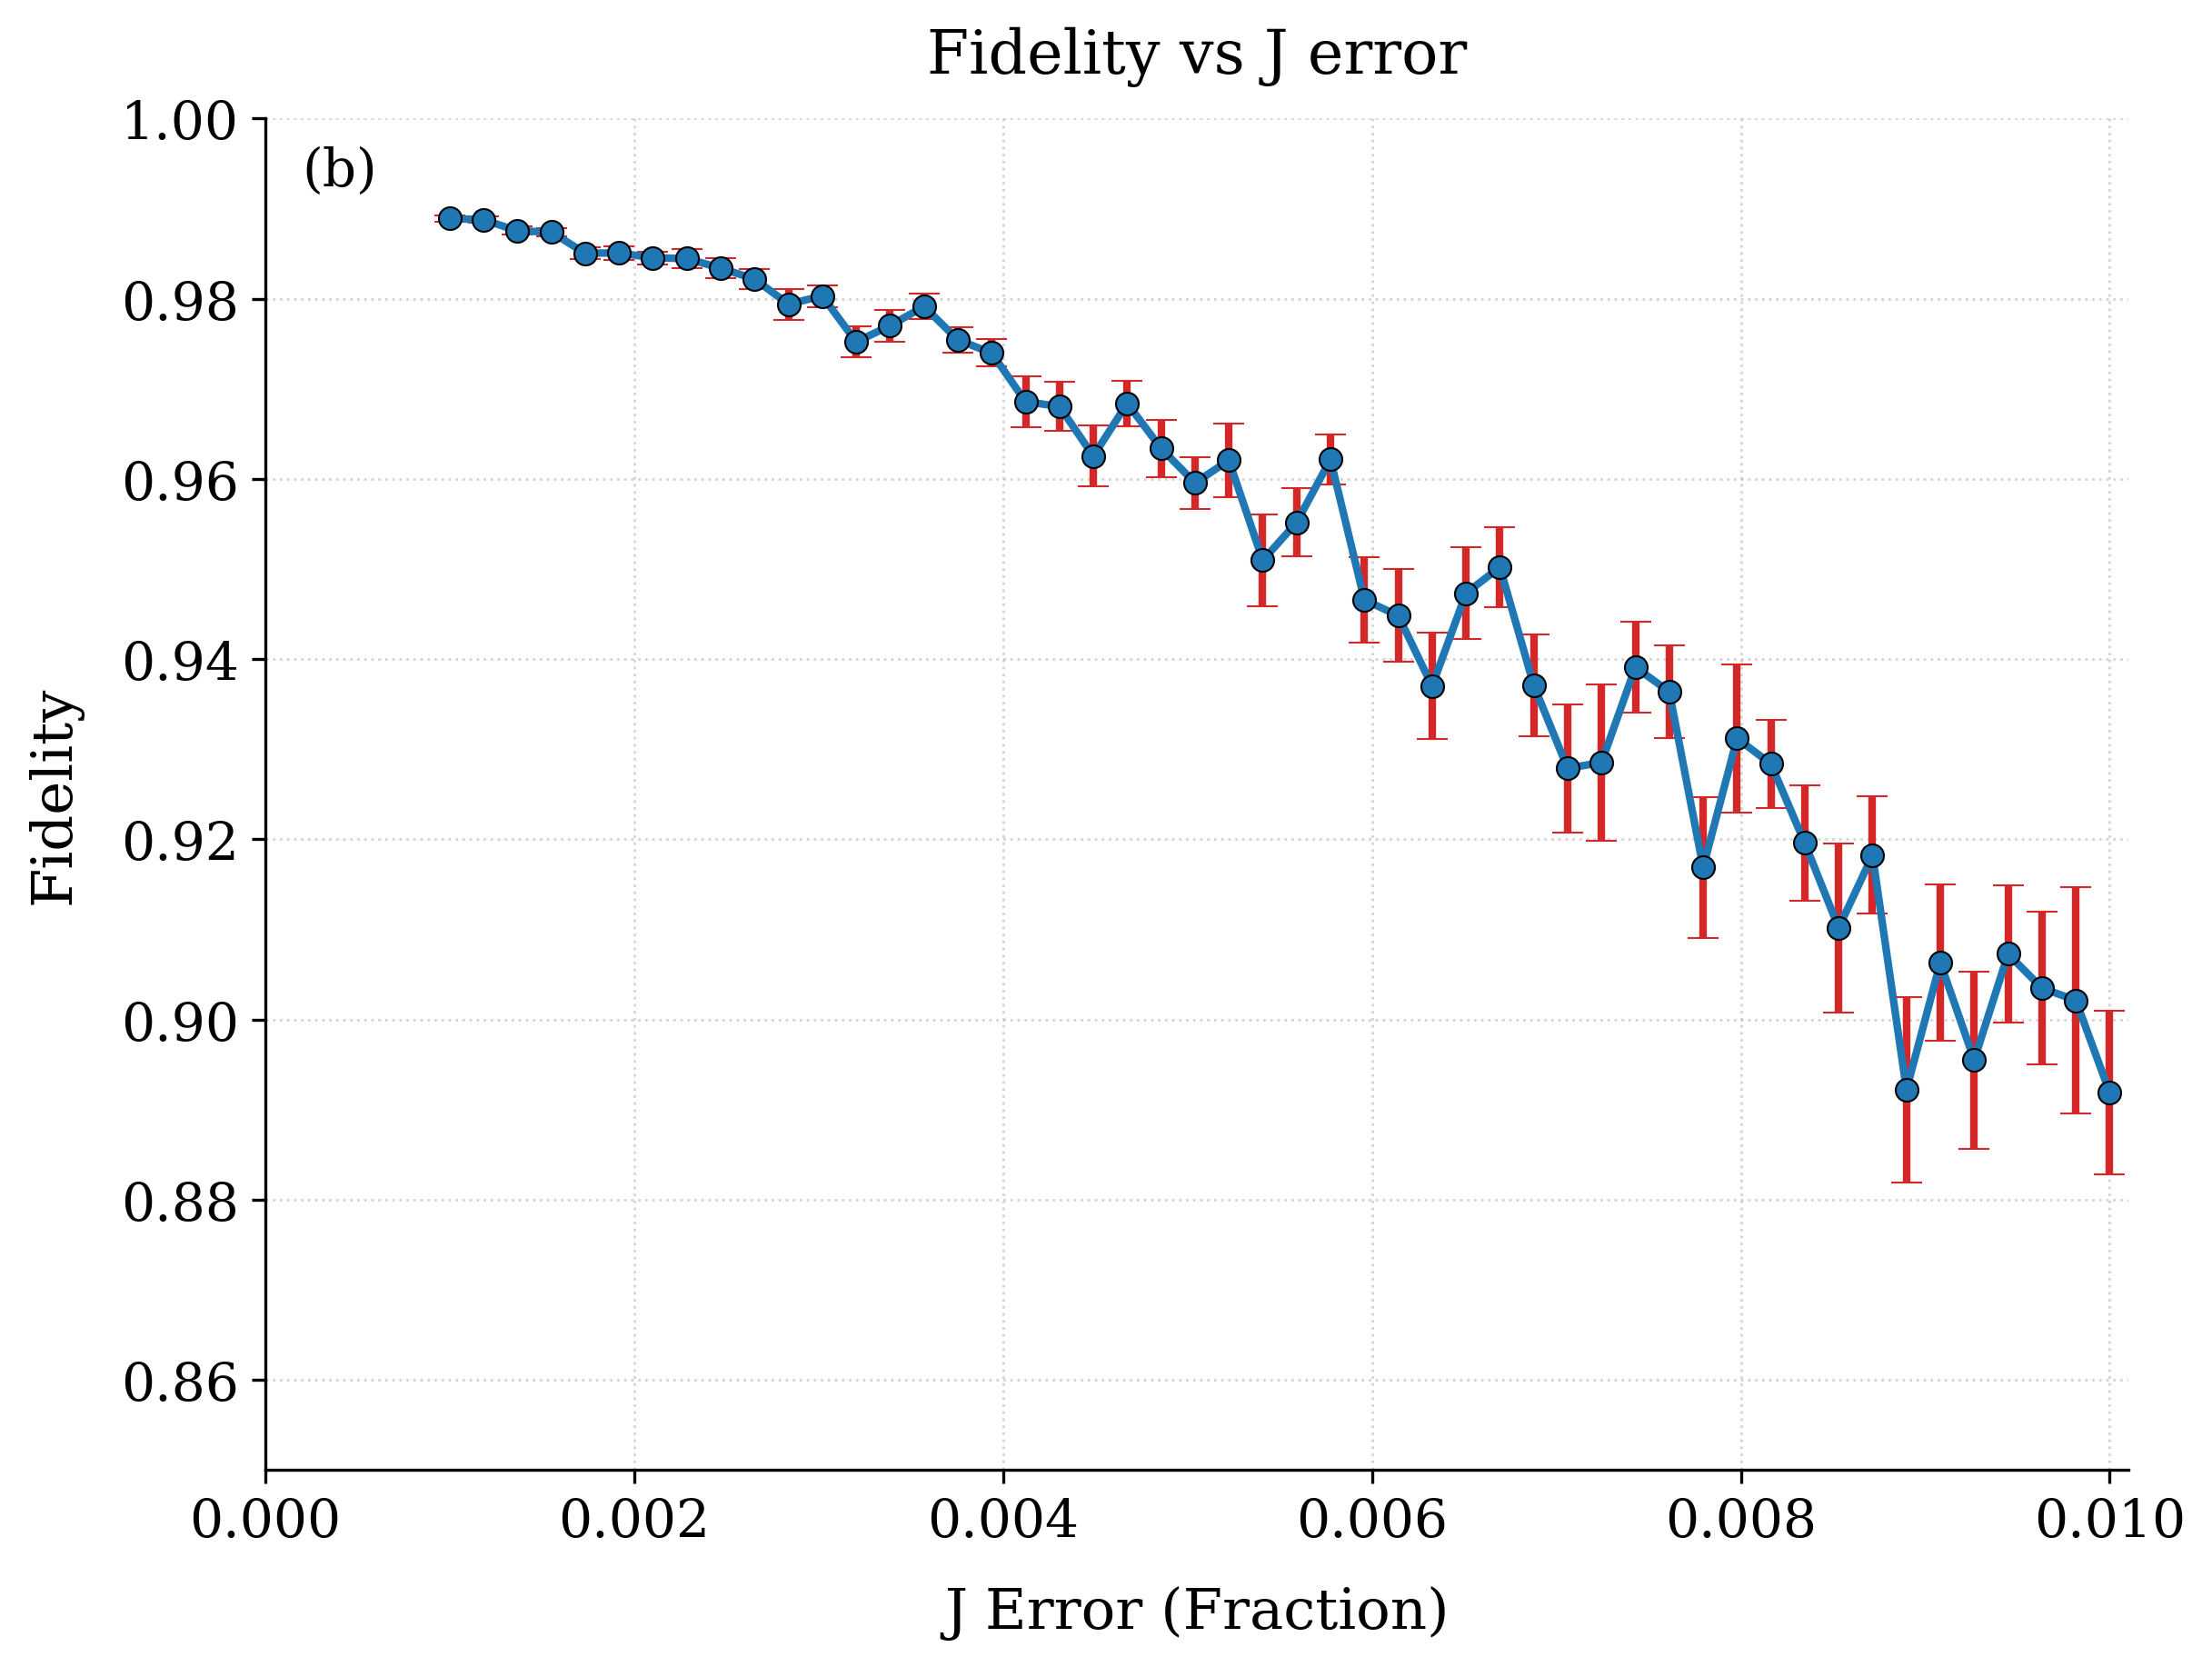

In [ ]:
# --- Save Figure with Professional Formatting ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)
z_error_scaled = [i*1000 for i in z_errors]
# Create errorbar plot with enhanced styling
errorbar = ax.errorbar(z_error_scaled[:], fidelity_means[:], yerr=fidelity_errors[:],
                     fmt='o-', color='#1f77b4', ecolor='#d62728', capsize=4,
                     markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                     linewidth=2, label='Fidelity')

# --- Professional Styling ---
# Axis labels with specified font sizes
ax.set_xlabel('Z strength (MHz)', fontsize=15, labelpad=10)
ax.set_ylabel('Fidelity', fontsize=15, labelpad=10)

# Title with context
title_str = f'Fidelity vs Z perturbation'
ax.set_title(title_str, fontsize=16, pad=12)

# Add panel label (a) in top-left corner
ax.text(0.02, 0.98, '(b)', transform=ax.transAxes, 
        fontsize=14, va='top', ha='left')

# Grid and tick styling
ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

# Axis limits and scaling
ax.set_ylim(0.85, 1.00)
ax.set_xlim(0, max(z_error_scaled[:])+0.01)

# Legend with professional styling
# legend = ax.legend(fontsize=12, frameon=True, framealpha=1, 
#                   edgecolor='k', loc='lower left')
# legend.get_frame().set_linewidth(0.8)

# Spine styling - remove top/right, adjust others
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_color('black')

# Save figure in multiple formats
figure_filename = f"./figures/figures_v3/z_errors/figure_fidelity_vs_lerr_{file_tag}"
plt.savefig(f"{figure_filename}.pdf", format='pdf', bbox_inches='tight', dpi=300)

plt.show()


In [19]:
import pandas as pd
import json
import os

def combine_z_error_data(file1_path, file2_path, output_dir='./data_files/combined_data'):
    """
    Combine two l_error data files into one, preserving all metadata and concatenating sweep results.
    
    Args:
        file1_path (str): Path to first Excel file
        file2_path (str): Path to second Excel file
        output_dir (str): Directory to save combined file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Load both files
    df1_inputs = pd.read_excel(file1_path, sheet_name='inputs')
    df1_data = pd.read_excel(file1_path, sheet_name='sweep_results')
    
    df2_inputs = pd.read_excel(file2_path, sheet_name='inputs')
    df2_data = pd.read_excel(file2_path, sheet_name='sweep_results')
    
    # Verify files are compatible (same parameters except error_range)
    compatible_params = ['N', 'J', 'lmd', 'initial_time', 'final_time', 
                        'step_number', 'iterations', 'state_dictionary', 'error_type']
    
    for param in compatible_params:
        val1 = df1_inputs[param].iloc[0]
        val2 = df2_inputs[param].iloc[0]
        
        # Special handling for state_dictionary which is JSON string
        if param == 'state_dictionary':
            val1 = json.loads(val1)
            val2 = json.loads(val2)
        
        if val1 != val2:
            raise ValueError(f"Incompatible {param} values: {val1} vs {val2}")
    
    # Combine the data
    combined_data = pd.concat([df1_data, df2_data], ignore_index=True)
    
    # Create new input data with combined error_range
    new_inputs = df1_inputs.iloc[0].to_dict()
    new_inputs['error_range'] = f"{combined_data['z_error'].min()} to {combined_data['z_error'].max()}"
    new_inputs['num_steps'] = len(combined_data)
    
    # Generate output filename based on original format
    state_dict = json.loads(new_inputs['state_dictionary'])
    state_str = '_'.join([f'{k}-{v}' for k, v in state_dict.items()])
    file_tag = f"N{new_inputs['N']}_J{new_inputs['J']}_lmd{new_inputs['lmd']}_{state_str}"
    output_filename = os.path.join(output_dir, f"data_sweep_N13_J0.5_lmd0.02272_1-1_combined.xlsx")
    
    # Save combined data
    with pd.ExcelWriter(output_filename, engine='openpyxl') as writer:
        pd.DataFrame([new_inputs]).to_excel(writer, sheet_name='inputs', index=False)
        combined_data.to_excel(writer, sheet_name='sweep_results', index=False)
    
    print(f"Successfully combined data saved to: {output_filename}")
    return output_filename



In [ ]:
# Example usage:
if __name__ == "__main__":
    file1 = "./data_files/data_v3/z_errors/data_sweep_N13_J0.5_lmd0.02272_1-1_1.xlsx"
    file2 = "./data_files/data_v3/z_errors/data_sweep_N13_J0.5_lmd0.02272_1-1_2.xlsx"
    
    combine_z_error_data(file1, file2, output_dir="./data_files/data_v3/z_errors/")

Successfully combined data saved to: ./data_files/data_v3/z_errors/data_sweep_N13_J0.5_lmd0.02272_1-1_combined.xlsx


In [97]:
# Example usage
if __name__ == "__main__":
    # Example file path
    file_path = "./data_files/data_v3/l_errors/data_sweep_N13_J0.5_lmd0.02272_1-1_combined.xlsx"
    
    try:
        data = read_simulation_data(file_path)
        
        # Access parameters
        print("System Parameters:")
        print(f"N = {data['input_params']['N']}")
        print(f"J = {data['input_params']['J']}")
        print(f"λ = {data['input_params']['lmd']}")
        print(f"Initial state: {data['input_params']['state_dictionary']}")
        
        # Access data arrays
        print("\nFirst 5 error values:", data['l_errors'][:5])
        print("Corresponding fidelities:", data['fidelity_means'][:5])
        
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except KeyError as e:
        print(f"Column missing in Excel file: {e}")
    except json.JSONDecodeError:
        print("Error decoding state_dictionary JSON")


        l_errors = data['l_errors']
        fidelity_means = data['fidelity_means']
        fidelity_errors = data['fidelity_errors']
    

Column missing in Excel file: 'j_error'


<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_19304\275644917.py:19: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ Error (Fraction)', fontsize=15, labelpad=10)
C:\Users\User\AppData\Local\Temp\ipykernel_19304\275644917.py:19: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ Error (Fraction)', fontsize=15, labelpad=10)


NameError: name 'z_errors' is not defined

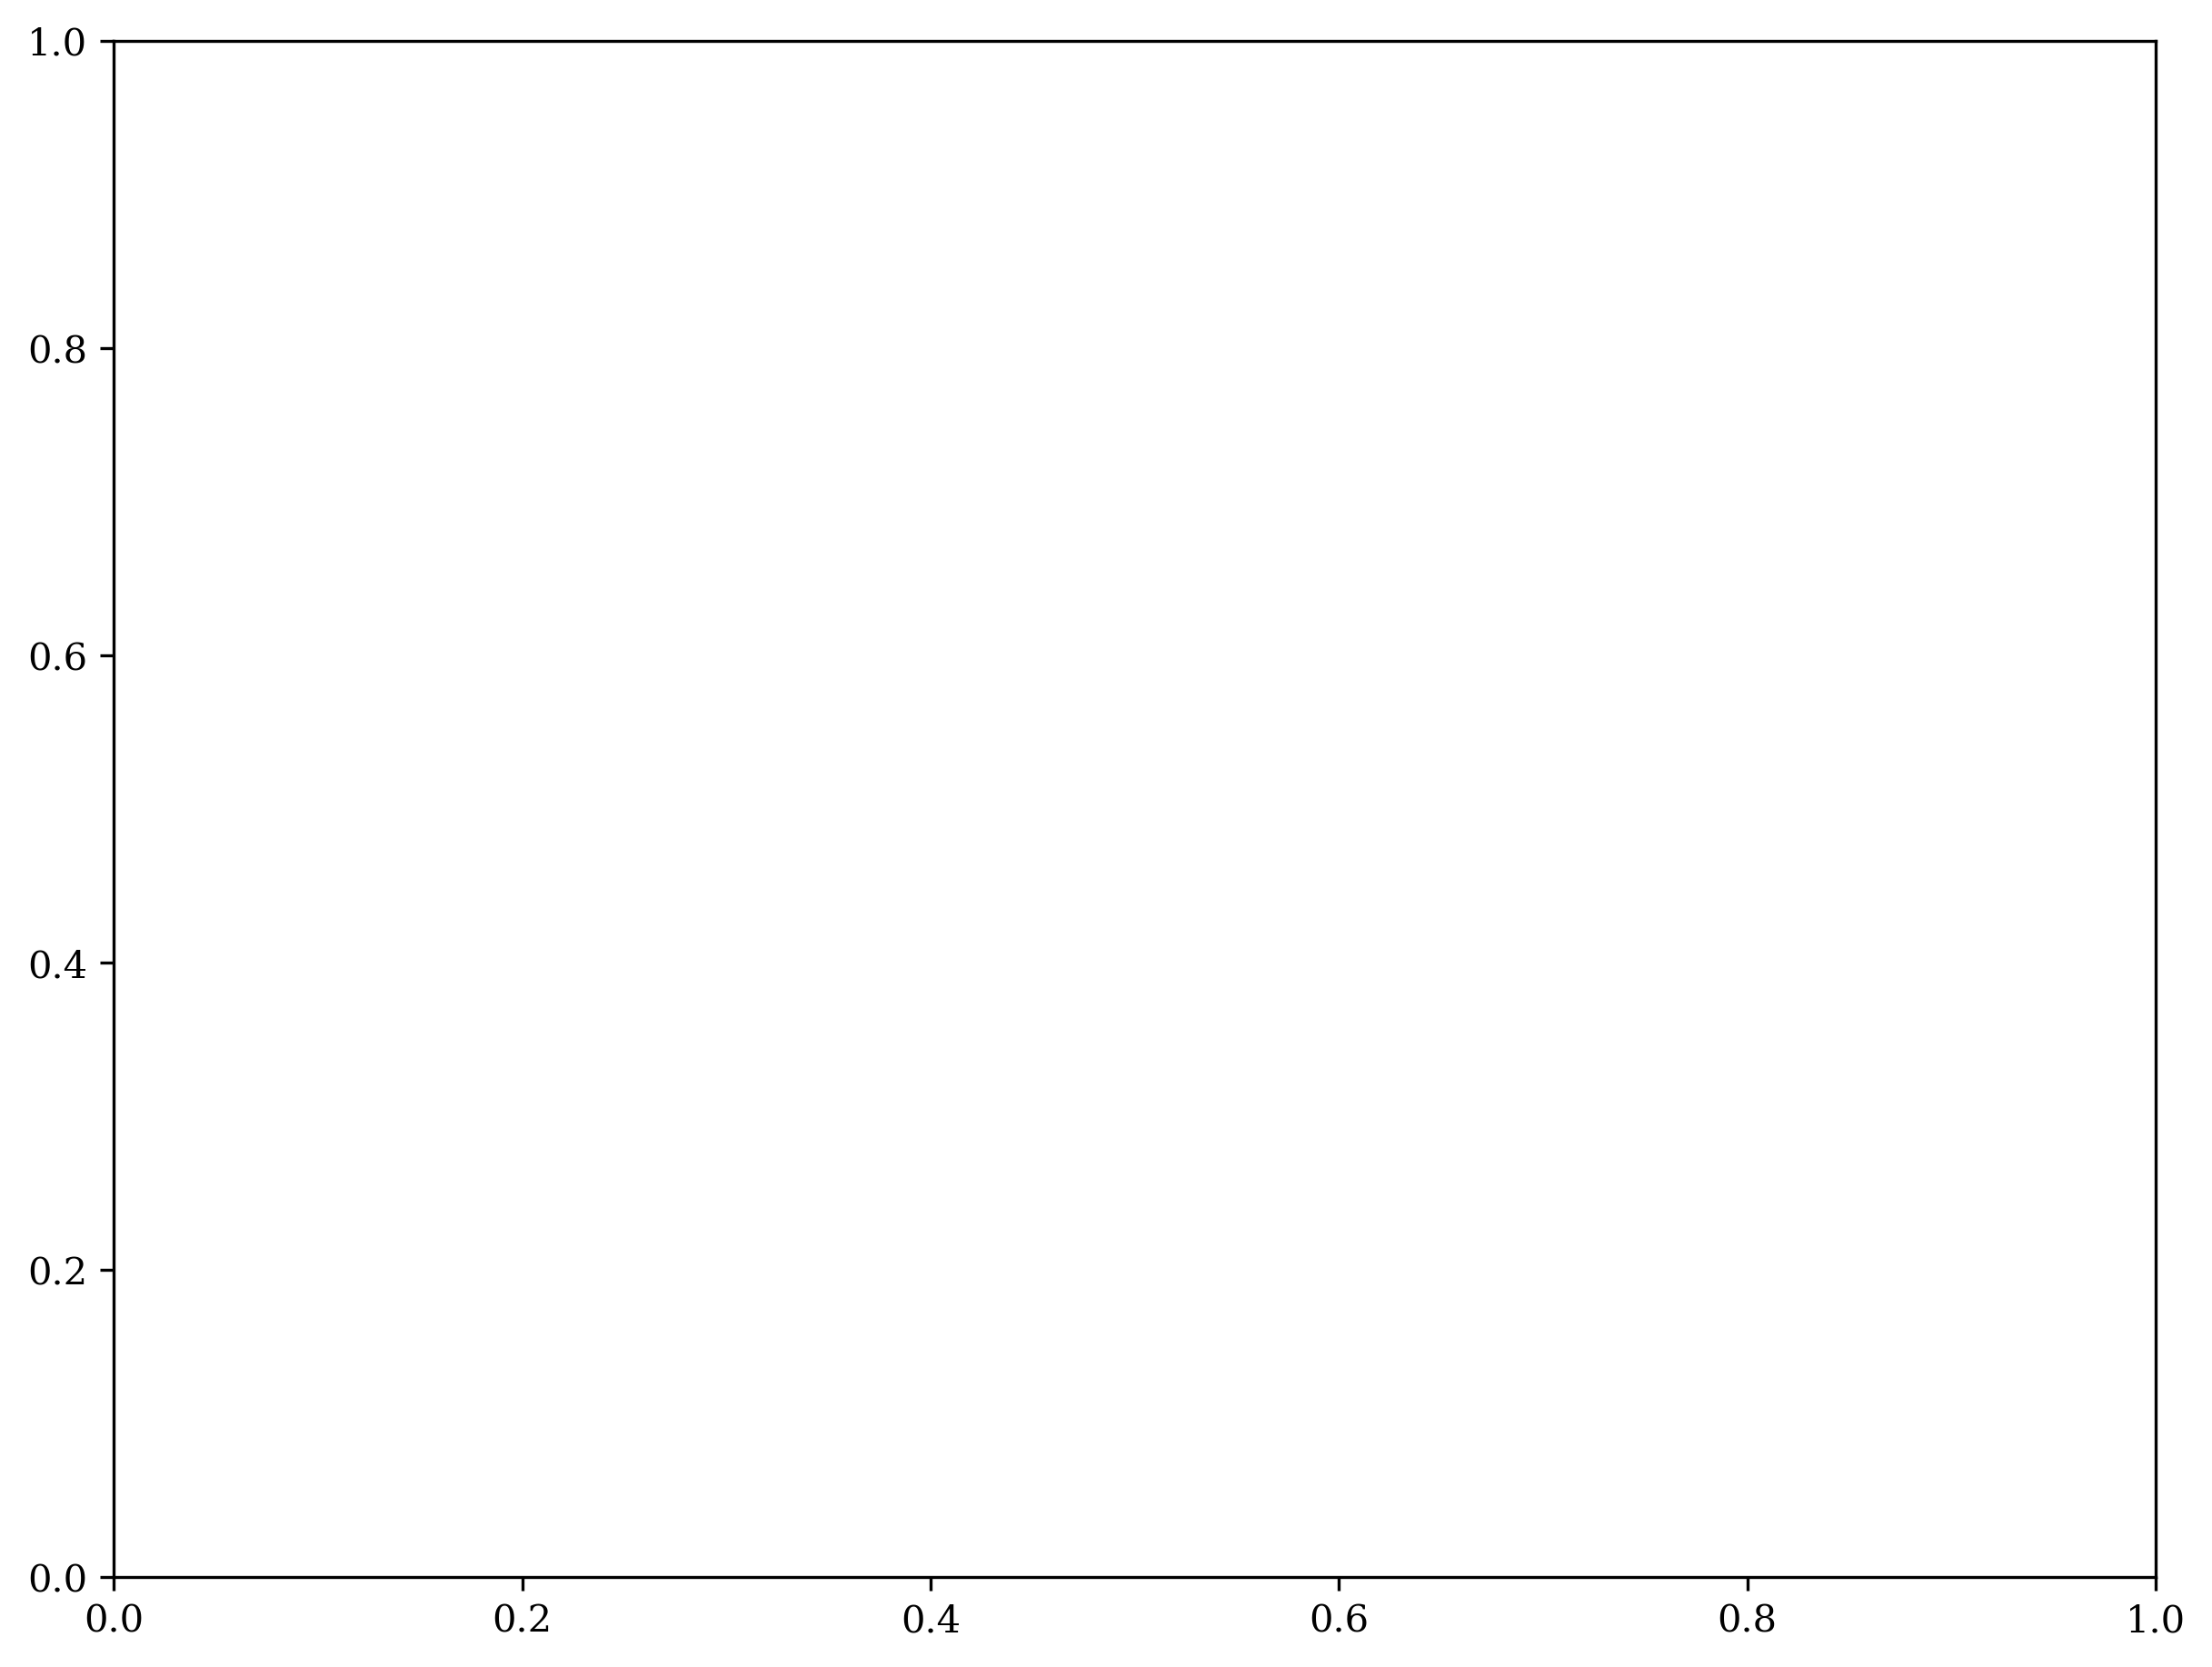

In [31]:
# --- Build file tag ---
state_str = '_'.join([f'{k}-{v}' for k, v in state_dictionary.items()])
file_tag = f"N{N}_J{J}_lmd{lmd}_{state_str}"

# --- Save Figure with Professional Formatting ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)
z_error_scaled = [i*1000 for i in z_errors]
# Create errorbar plot with enhanced styling
errorbar = ax.errorbar(l_errors[:], fidelity_means[:], yerr=fidelity_errors[:],
                     fmt='o-', color='#1f77b4', ecolor='#d62728', capsize=4,
                     markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                     linewidth=2, label='Fidelity')

# --- Professional Styling ---
# Axis labels with specified font sizes
ax.set_xlabel('$\lambda$ Error (Fraction)', fontsize=15, labelpad=10)
ax.set_ylabel('Fidelity', fontsize=15, labelpad=10)

# Title with context
title_str = f'Fidelity vs Transverse field error'
ax.set_title(title_str, fontsize=16, pad=12)

# # Add panel label (a) in top-left corner
# ax.text(0.02, 0.98, '(a)', transform=ax.transAxes, 
#         fontsize=14, va='top', ha='left')

# Grid and tick styling
ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

# Axis limits and scaling
ax.set_ylim(0.8, 1.00)
ax.set_xlim(0, max(l_errors[:])+0.001)

# Legend with professional styling
# legend = ax.legend(fontsize=12, frameon=True, framealpha=1, 
#                   edgecolor='k', loc='lower left')
# legend.get_frame().set_linewidth(0.8)

# Spine styling - remove top/right, adjust others
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_color('black')

# Save figure in multiple formats
figure_filename = f"./figures/figures_v3/l_errors/figure_fidelity_vs_lerr_{file_tag}"
plt.savefig(f"{figure_filename}.png", format='png', bbox_inches='tight', dpi=300)

plt.show()

In [52]:
fid_7 = fidelity_means
err_7 = fidelity_errors

In [53]:
fid_8 = fidelity_means
err_8 = fidelity_errors

In [54]:
fid_9 = fidelity_means
err_9 = fidelity_errors

In [23]:
def read_combined_l_error_data(file_path):
    """
    Read a combined z-error data file and return the data in a structured format for plotting.
    
    Args:
        file_path (str): Path to the combined Excel file
        
    Returns:
        dict: A dictionary containing:
            - 'inputs': Dictionary of input parameters
            - 'sweep_results': DataFrame with all sweep data
            - 'state_dictionary': Parsed state dictionary
            - 'error_range': Tuple of (min_error, max_error)
    """
    # Load the data
    inputs_df = pd.read_excel(file_path, sheet_name='inputs')
    sweep_results_df = pd.read_excel(file_path, sheet_name='sweep_results')
    
    # Convert inputs to dictionary
    inputs = inputs_df.iloc[0].to_dict()
    
    # Parse the state dictionary
    state_dict = json.loads(inputs['state_dictionary'])
    
    # Parse error range
    min_error = sweep_results_df['l_error'].min()
    max_error = sweep_results_df['l_error'].max()
    
    return {
        'inputs': inputs,
        'sweep_results': sweep_results_df,
        'state_dictionary': state_dict,
        'error_range': (min_error, max_error)
    }

In [16]:
def read_combined_z_error_data(file_path):
    """
    Read a combined z-error data file and return the data in a structured format for plotting.
    
    Args:
        file_path (str): Path to the combined Excel file
        
    Returns:
        dict: A dictionary containing:
            - 'inputs': Dictionary of input parameters
            - 'sweep_results': DataFrame with all sweep data
            - 'state_dictionary': Parsed state dictionary
            - 'error_range': Tuple of (min_error, max_error)
    """
    # Load the data
    inputs_df = pd.read_excel(file_path, sheet_name='inputs')
    sweep_results_df = pd.read_excel(file_path, sheet_name='sweep_results')
    
    # Convert inputs to dictionary
    inputs = inputs_df.iloc[0].to_dict()
    
    # Parse the state dictionary
    state_dict = json.loads(inputs['state_dictionary'])
    
    # Parse error range
    min_error = sweep_results_df['z_error'].min()
    max_error = sweep_results_df['z_error'].max()
    
    return {
        'inputs': inputs,
        'sweep_results': sweep_results_df,
        'state_dictionary': state_dict,
        'error_range': (min_error, max_error)
    }

In [24]:
# Read the combined data file
data = read_combined_l_error_data('./data_files/data_v3/safety_files/data_sweep_N13_J0.5_lmd0.02272_1-1_lambda.xlsx')

# Access the data for plotting
inputs = data['inputs']
sweep_results = data['sweep_results']
state_dict = data['state_dictionary']
min_error, max_error = data['error_range']

errors_l = sweep_results['l_error'].values
fidelities_l = sweep_results['fidelity_mean'].values
bars_l = sweep_results['fidelity_error'].values

In [17]:
# Read the combined data file
data = read_combined_z_error_data('./data_files/data_v3/z_errors/data_sweep_N13_J0.5_lmd0.02272_1-1_combined.xlsx')

# Access the data for plotting
inputs = data['inputs']
sweep_results = data['sweep_results']
state_dict = data['state_dictionary']
min_error, max_error = data['error_range']

In [18]:
errors_z = sweep_results['z_error'].values
fidelities_z = sweep_results['fidelity_mean'].values
bars_z = sweep_results['fidelity_error'].values


In [28]:
# Example usage
if __name__ == "__main__":
    # Example file path (replace with your actual file)
    example_file = "./data_files/data_v3/safety_files/data_sweep_N13_J0.5_lmd0.02272_1-1_good.xlsx"
    
    # Read the data
    simulation_data = read_simulation_data(example_file)
    
    # Access the input parameters
    params = simulation_data['input_parameters']
    print("Input Parameters:")
    print(f"N = {params['N']}")
    print(f"J = {params['J']}")
    print(f"λ = {params['lmd']}")
    print(f"State = {params['state_dictionary']}")
    print(f"Error range: {params['error_range']}")
    print(f"Number of steps: {params['num_steps']}")


    j_errors = simulation_data['j_errors']
    fidelity_means = simulation_data['fidelity_means']
    fidelity_errors = simulation_data['fidelity_errors']

KeyError: 'input_parameters'

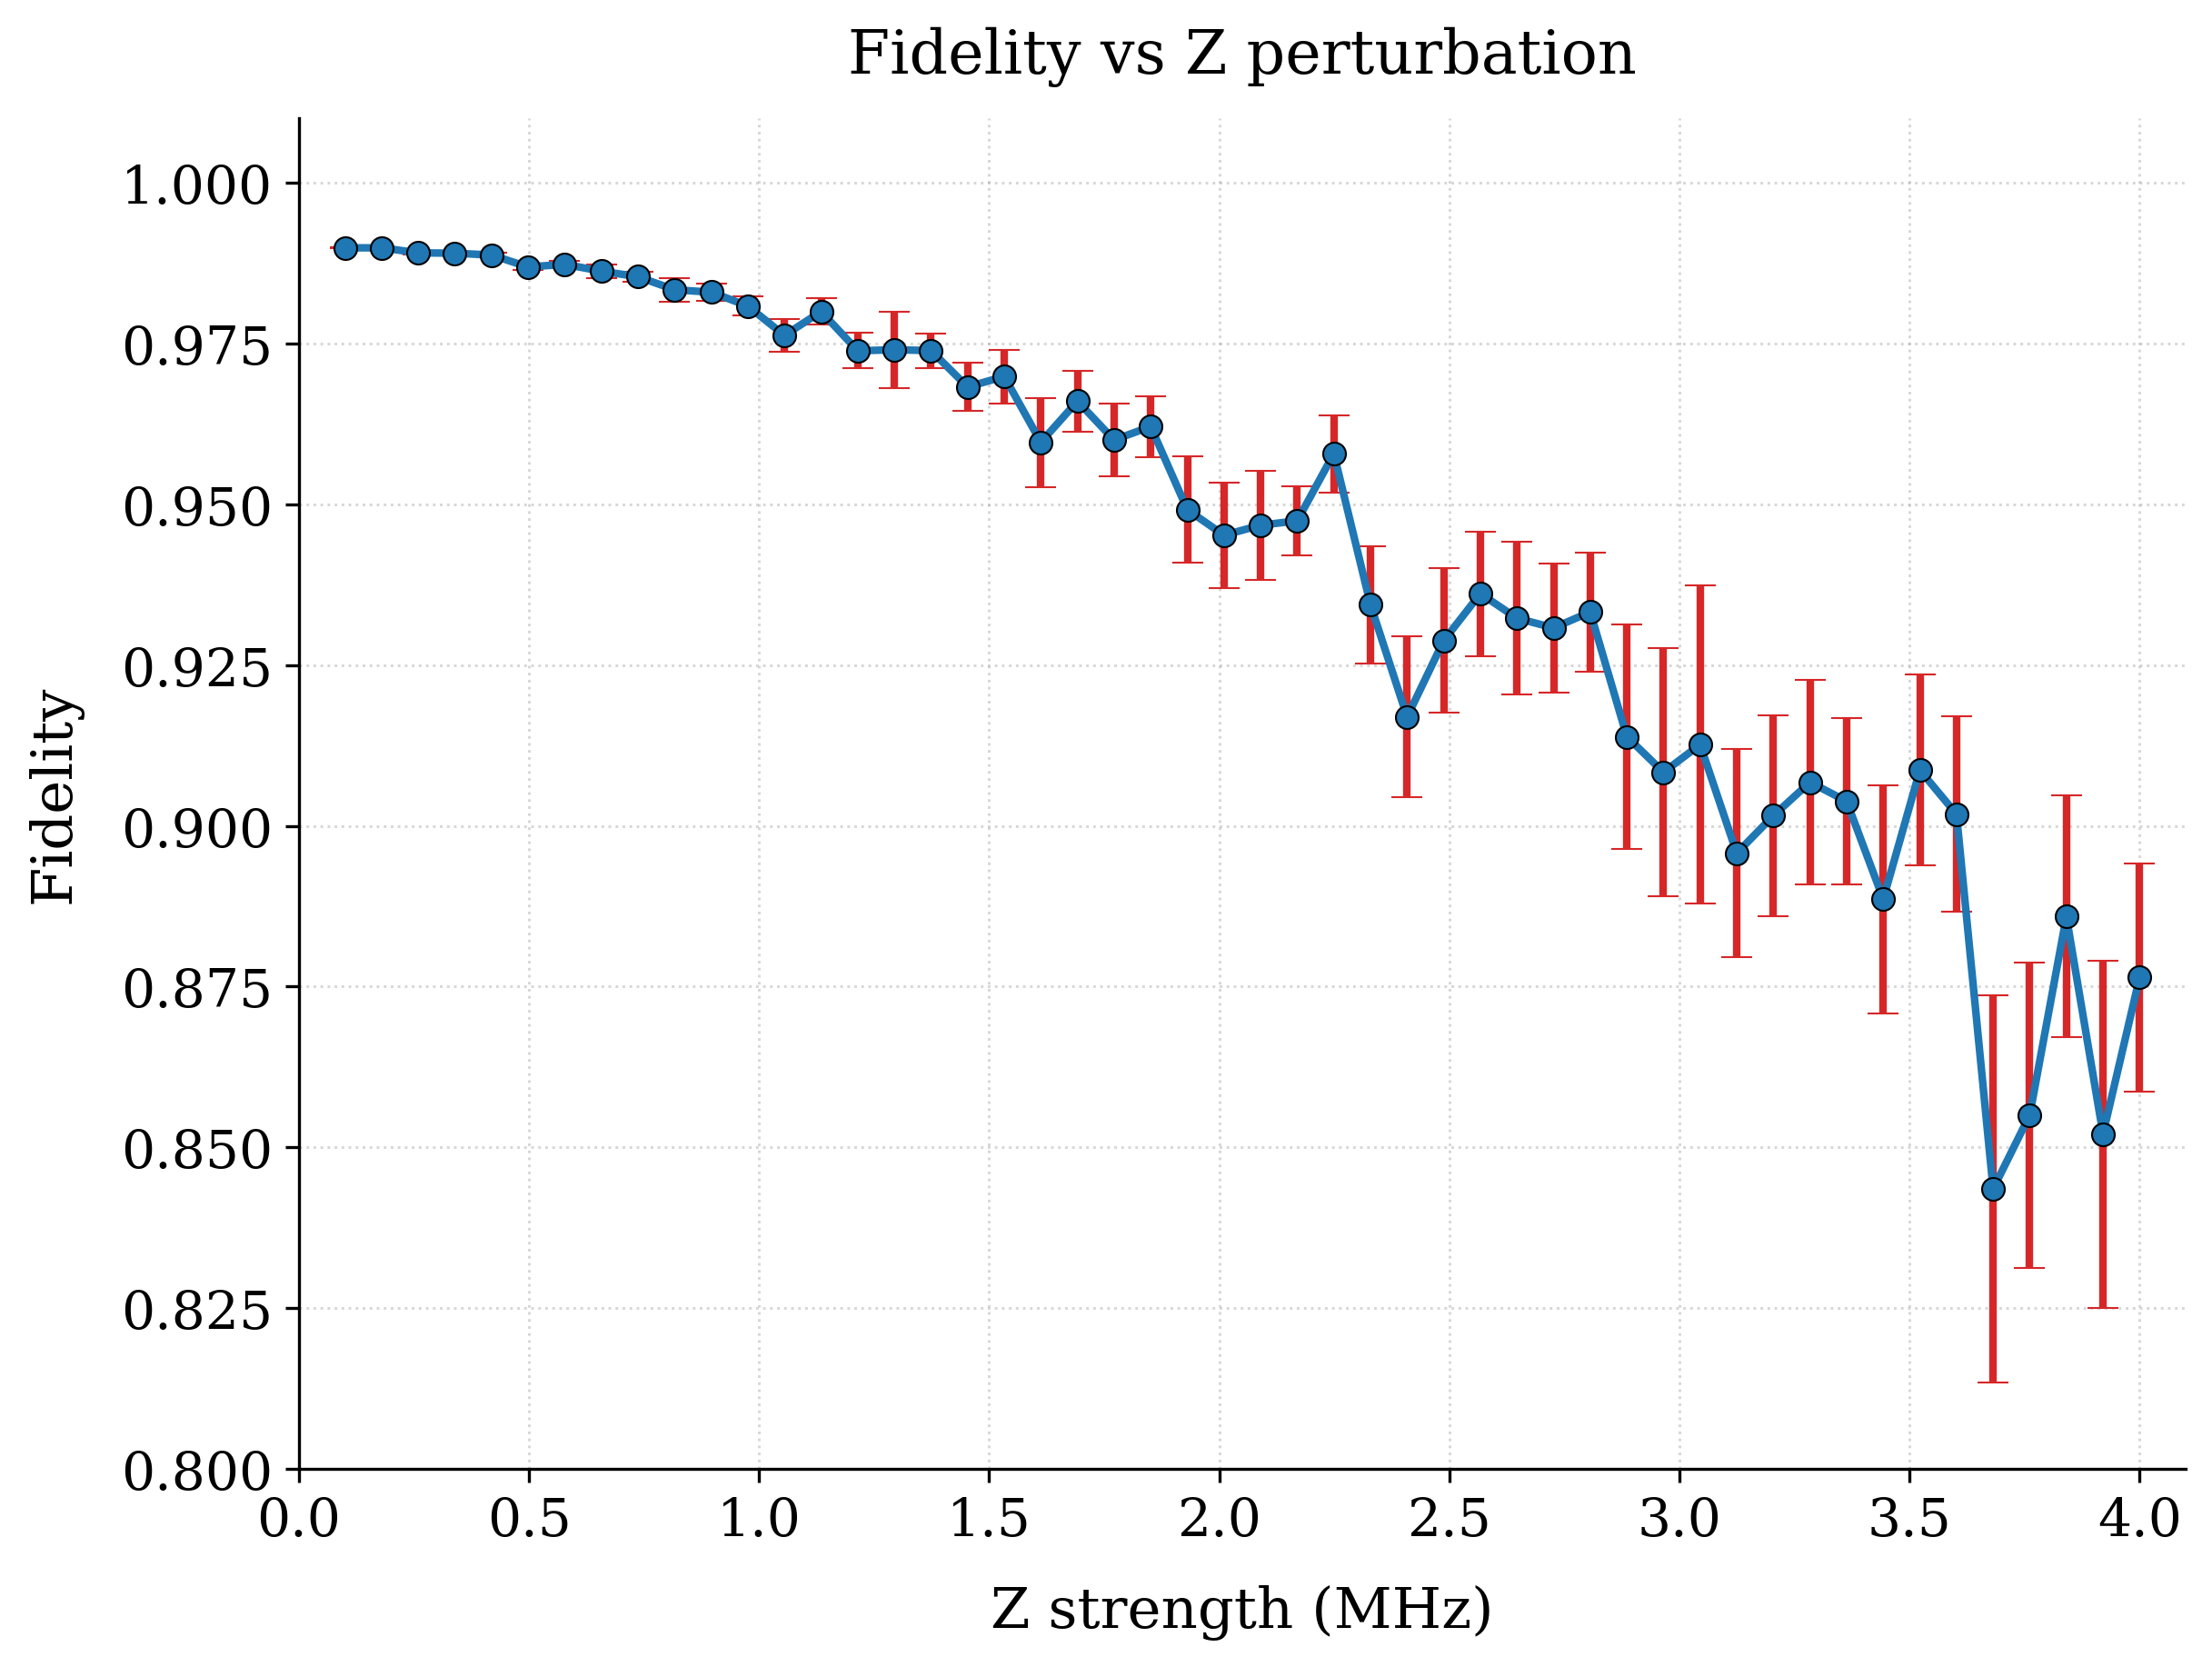

In [32]:
file_tag = f"N_13_J_0.5_lmd0.2272_11"

# --- Save Figure with Professional Formatting ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)
z_error_scaled = [i*1000 for i in errors_z]
# Create errorbar plot with enhanced styling
errorbar = ax.errorbar(z_error_scaled[:], fidelities_z[:], yerr=bars_z[:],
                     fmt='o-', color='#1f77b4', ecolor='#d62728', capsize=4,
                     markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                     linewidth=2, label='Fidelity')

# --- Professional Styling ---
# Axis labels with specified font sizes
ax.set_xlabel('Z strength (MHz)', fontsize=15, labelpad=10)
ax.set_ylabel('Fidelity', fontsize=15, labelpad=10)

# Title with context
title_str = f'Fidelity vs Z perturbation'
ax.set_title(title_str, fontsize=16, pad=12)

# Add panel label (a) in top-left corner
# ax.text(0.02, 0.98, '(c)', transform=ax.transAxes, 
#         fontsize=14, va='top', ha='left')

# Grid and tick styling
ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)

# Axis limits and scaling
ax.set_ylim(0.8, 1.01)
ax.set_xlim(0, max(z_error_scaled[:])+0.1)

# Legend with professional styling
# legend = ax.legend(fontsize=12, frameon=True, framealpha=1, 
#                   edgecolor='k', loc='lower left')
# legend.get_frame().set_linewidth(0.8)

# Spine styling - remove top/right, adjust others
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(0.8)
    ax.spines[spine].set_color('black')

# Save figure in multiple formats
figure_filename = f"./figures/presentation/figure_fidelity_vs_zerr_{file_tag}"
plt.savefig(f"{figure_filename}.png", format='png', bbox_inches='tight', dpi=300)

plt.show()


<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_19304\1149265480.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$\lambda$ Error (Fraction)', fontsize=15, labelpad=12)
C:\Users\User\AppData\Local\Temp\ipykernel_19304\1149265480.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.0)


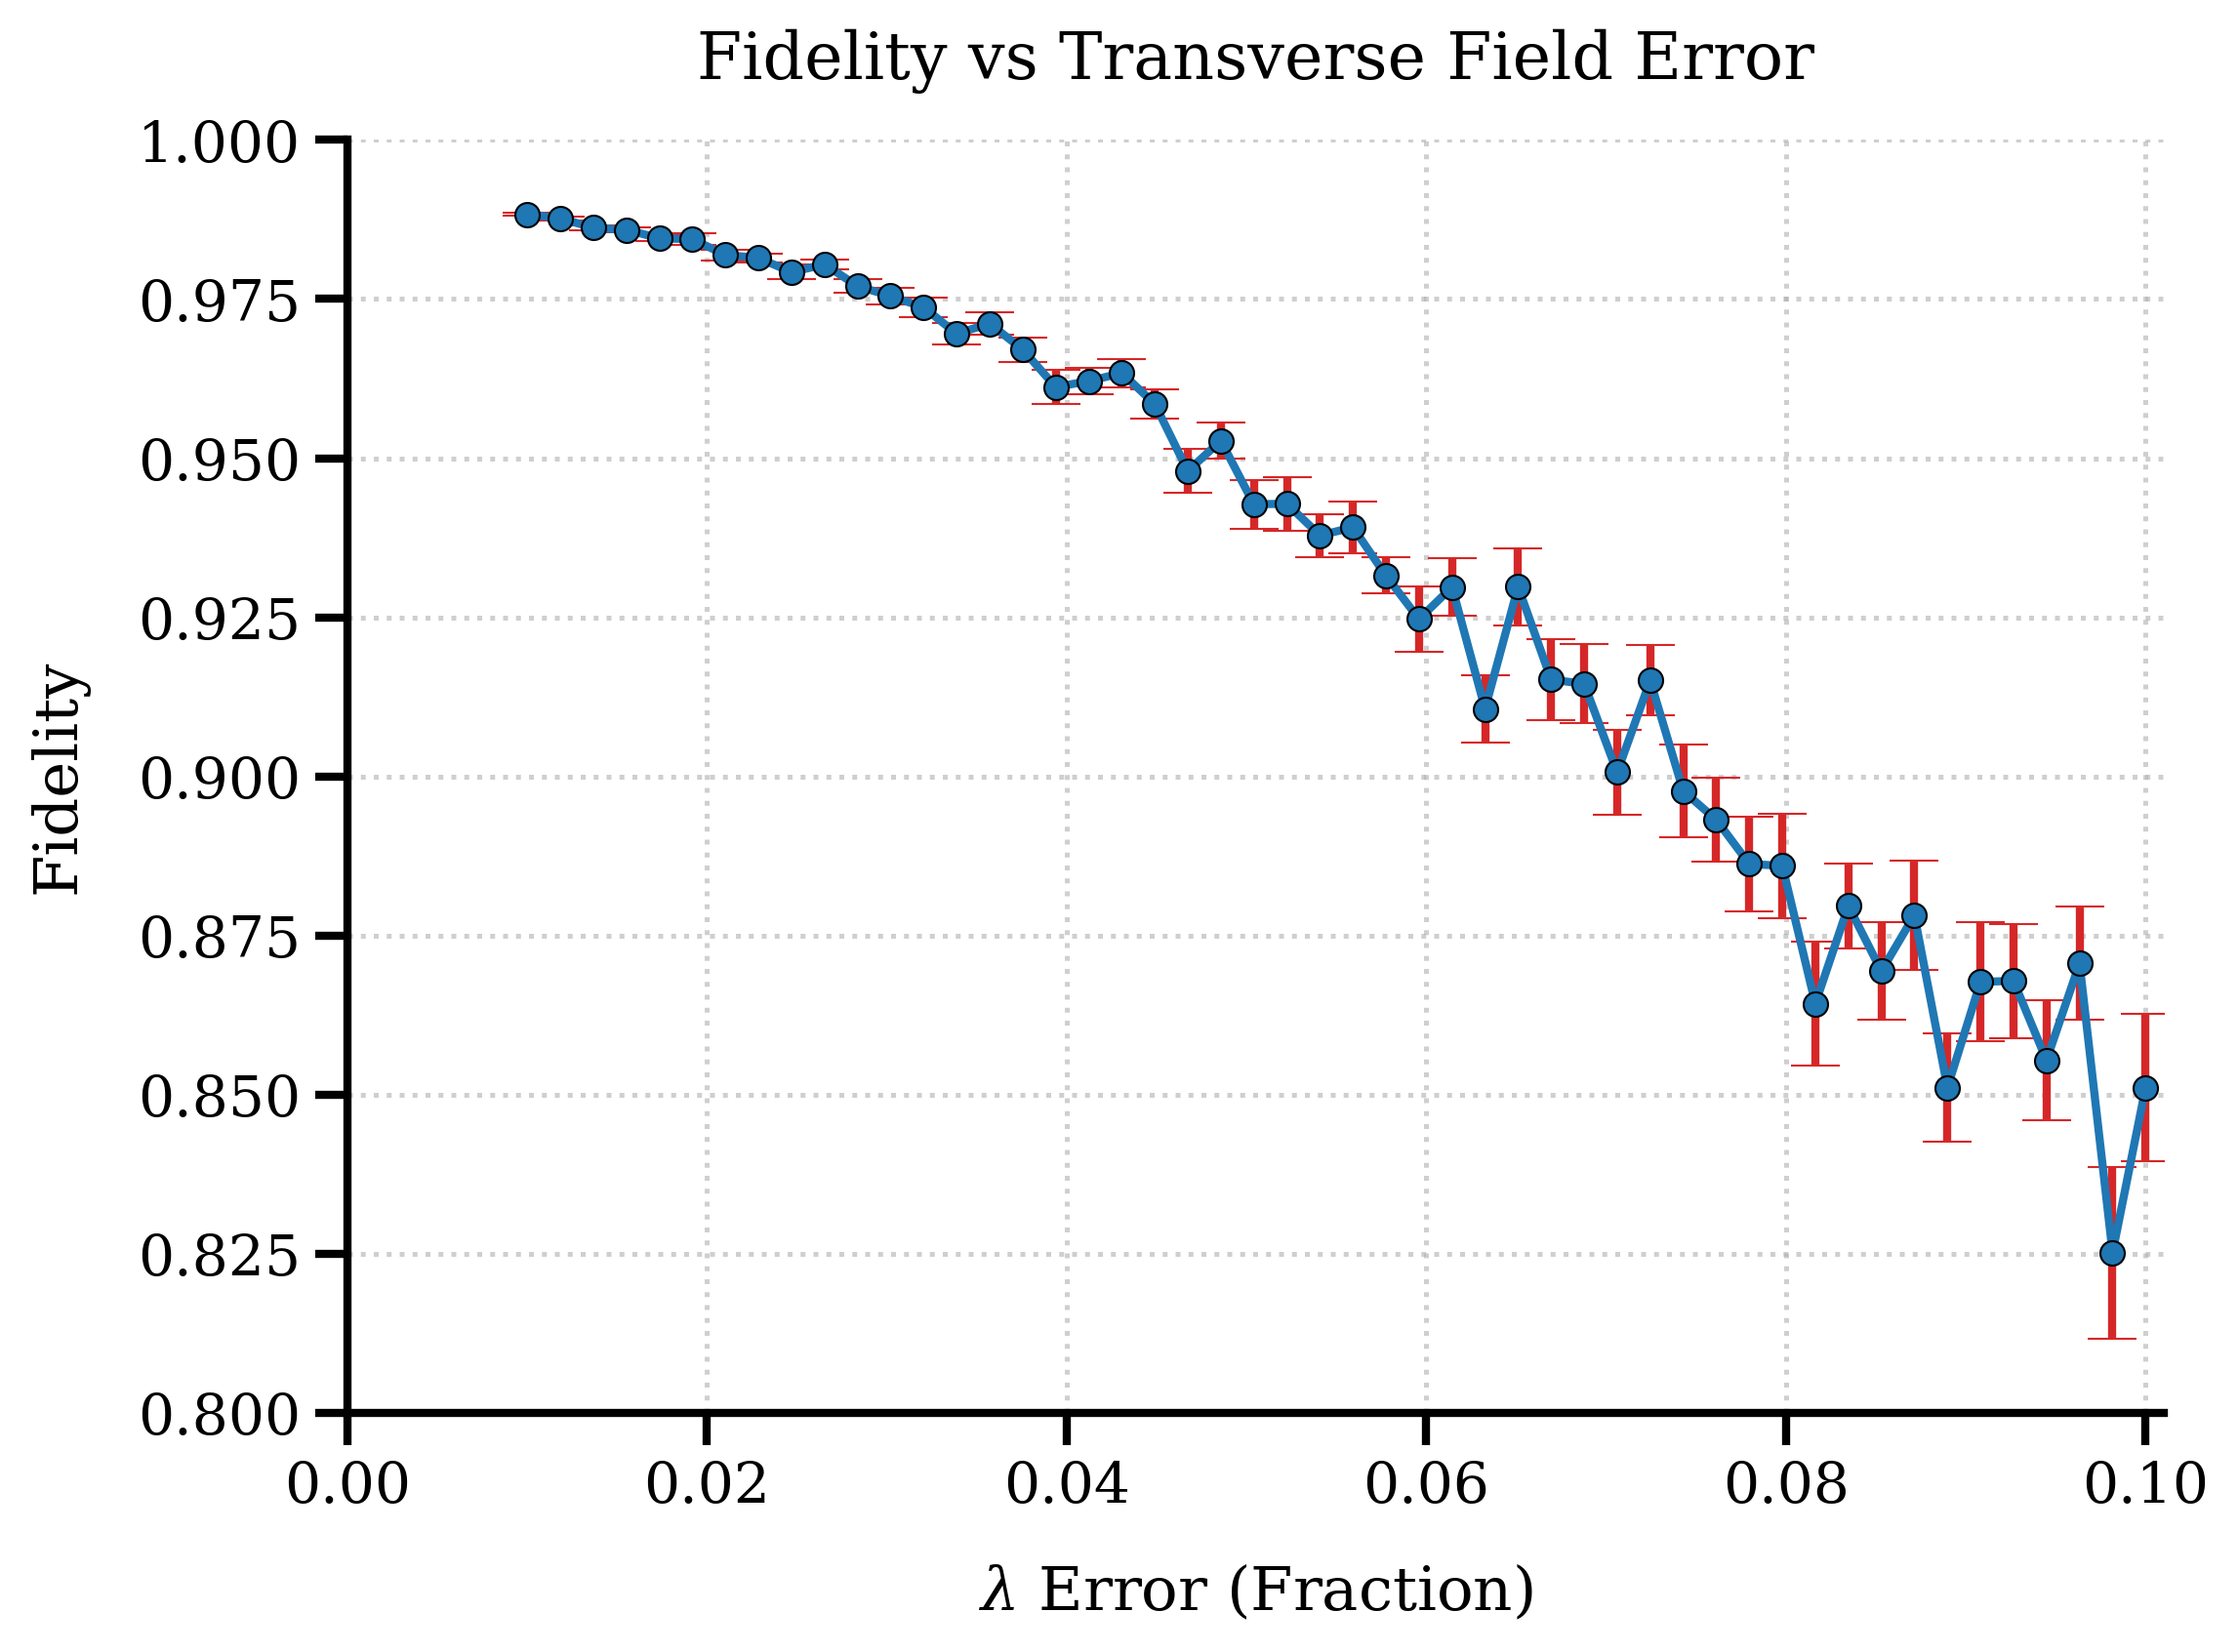

In [37]:
state_dictionary = {"1":1}
N=13
lmd = 0.02272
J = 0.5
state_str = '_'.join([f'{k}-{v}' for k, v in state_dictionary.items()])
file_tag = f"N{N}_J{J}_lmd{lmd}_{state_str}"

# --- Plot with Complete Poster Formatting ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)

# Enhanced errorbar styling (matching reference plot)
errorbar = ax.errorbar(errors_l[:], fidelities_l[:], yerr=bars_l[:],
                      fmt='o-', color='#1f77b4', ecolor='#d62728', capsize=6,
                      markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                      linewidth=2, label='Fidelity')

# --- Complete Poster Styling ---
# Title and labels (matching reference sizes)
ax.set_title('Fidelity vs Transverse Field Error', fontsize=16, pad=15)
ax.set_xlabel('$\lambda$ Error (Fraction)', fontsize=15, labelpad=12)
ax.set_ylabel('Fidelity', fontsize=15, labelpad=12)

# # Panel label (scaled up)
# ax.text(0.02, 0.98, '(a)', transform=ax.transAxes, 
#         fontsize=24, va='top', ha='left', weight='bold')

# Grid and ticks (matching reference)
ax.grid(True, which='both', linestyle=':', linewidth=1.2, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=8)
ax.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=6)

# Axis limits
ax.set_ylim(0.8, 1.00)
ax.set_xlim(0, max(errors_l[:])+0.001)

# # Legend (matching reference styling)
# legend = ax.legend(fontsize=18, frameon=True, framealpha=1,
#                   edgecolor='k', handlelength=1.5)
# legend.get_frame().set_linewidth(1.2)

# Spines (matching reference)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')

# Layout and saving
plt.tight_layout(pad=2.0)
figure_filename = f"./figures/presentation/figures_v3_poster_figure_fidelity_vs_lerr_{file_tag}"
plt.savefig(f"{figure_filename}.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figure_filename}.png", bbox_inches='tight', dpi=300)
plt.show()

In [28]:
# --- Load Excel File ---
excel_filename = "./data_files/data_v3/safety_files/data_sweep_N13_J0.5_lmd0.02272_1-1_good.xlsx"  # Update as needed
with pd.ExcelFile(excel_filename) as xls:
    # Read both sheets
    inputs_df = pd.read_excel(xls, sheet_name='inputs')
    sweep_df = pd.read_excel(xls, sheet_name='sweep_results')

# --- Extract Metadata ---
input_data = inputs_df.iloc[0].to_dict()
input_data['state_dictionary'] = json.loads(input_data['state_dictionary'])  # parse back from JSON string

# Optional: print to check
print("Loaded Input Parameters:")
for key, value in input_data.items():
    print(f"{key}: {value}")

# --- Access Sweep Data ---
j_errors = sweep_df['j_error'].values
fidelity_means = sweep_df['fidelity_mean'].values
fidelity_errors = sweep_df['fidelity_error'].values
magnetization_means = sweep_df['magnetization_mean'].values
magnetization_errors = sweep_df['magnetization_error'].values




Loaded Input Parameters:
N: 13
J: 0.5
lmd: 0.02272
initial_time: 0
final_time: 150
step_number: 500
iterations: 25
state_dictionary: {'1': 1}
error_type: j_err
error_range: 0.001 to 0.01
num_steps: 50


C:\Users\User\AppData\Local\Temp\ipykernel_19304\605501815.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.0)


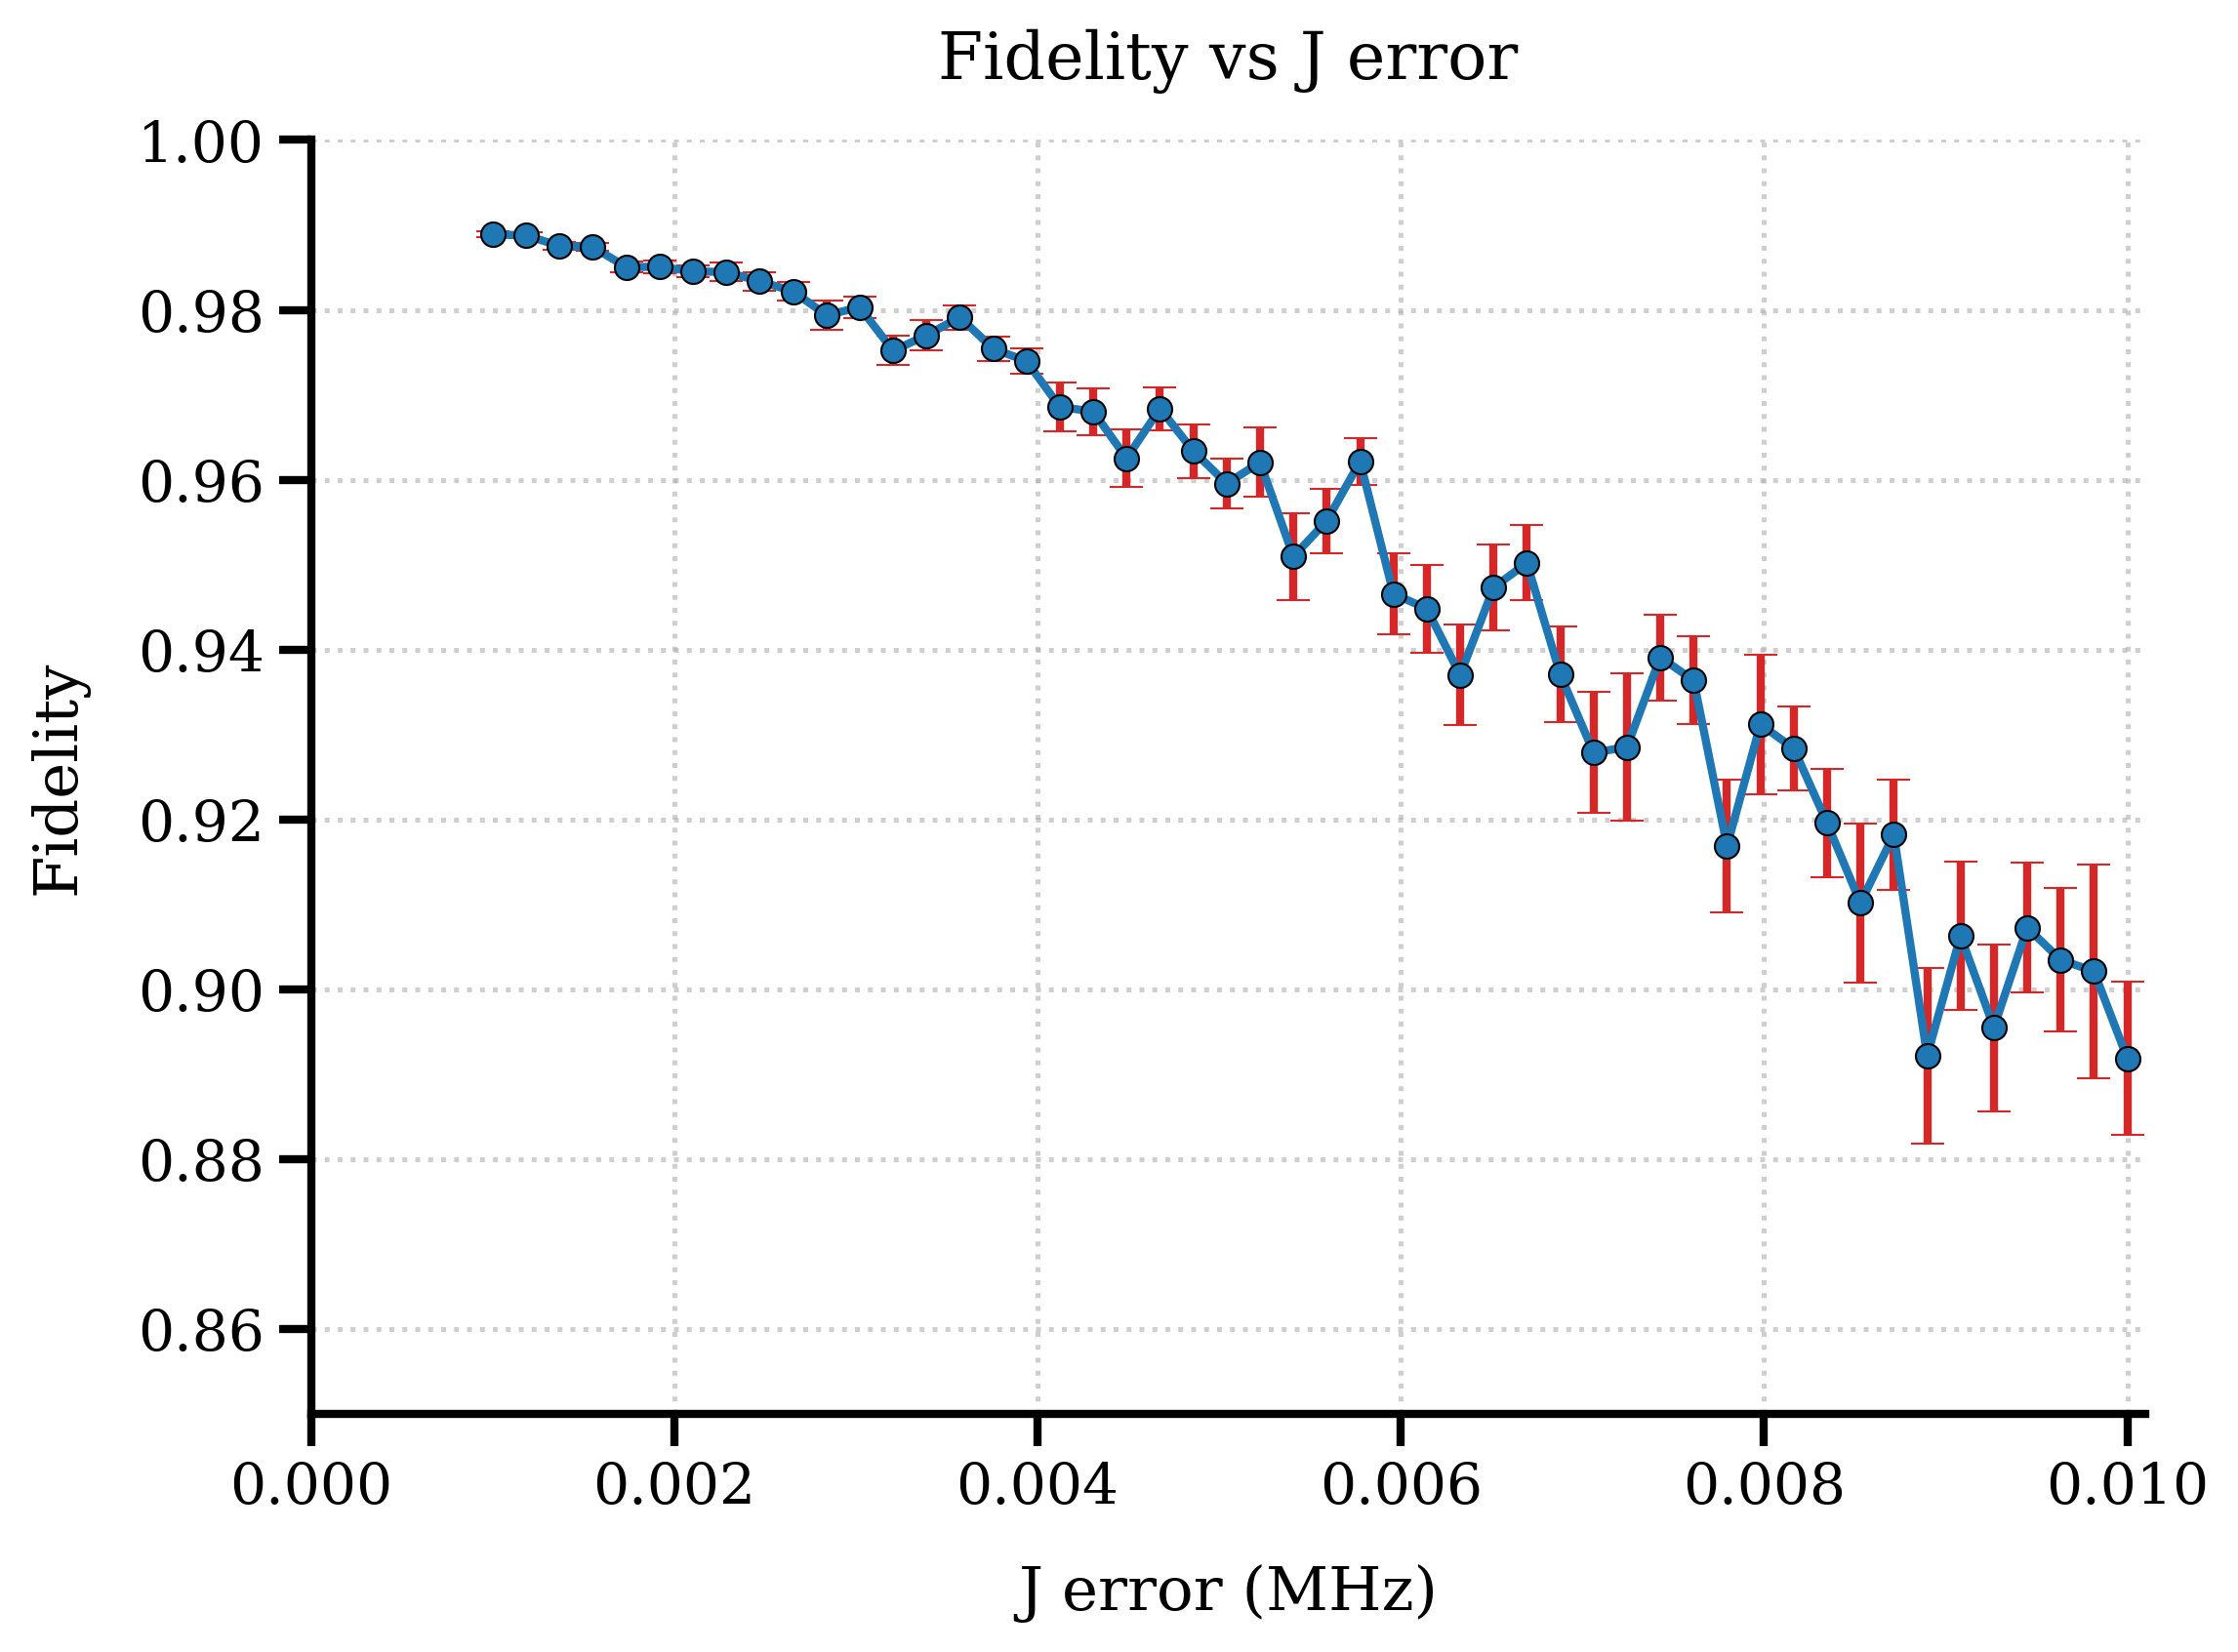

In [38]:
# --- Plot with Complete Poster Formatting ---
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)

# Enhanced errorbar styling (matching reference)
errorbar = ax.errorbar(j_errors[:], fidelity_means[:], yerr=fidelity_errors[:],
                      fmt='o-', color='#1f77b4', ecolor='#d62728', capsize=4,
                      markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                      linewidth=2, label='Fidelity')

# --- Complete Poster Styling ---
ax.set_title('Fidelity vs J error', fontsize=16, pad=15)
ax.set_xlabel('J error (MHz)', fontsize=15, labelpad=12)
ax.set_ylabel('Fidelity', fontsize=15, labelpad=12)

# # Panel label
# ax.text(0.02, 0.98, '(b)', transform=ax.transAxes, 
#         fontsize=24, va='top', ha='left', weight='bold')

# Grid and ticks (matching reference)
ax.grid(True, which='both', linestyle=':', linewidth=1.2, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=8)
ax.tick_params(axis='both', which='minor', labelsize=12, width=1.5, length=6)

# Axis limits
ax.set_ylim(0.85, 1.00)
ax.set_xlim(0, max(j_errors[:])+0.0001)

# # Legend (matching reference)
# legend = ax.legend(fontsize=18, frameon=True, framealpha=1,
#                   edgecolor='k', handlelength=1.5)
# legend.get_frame().set_linewidth(1.2)

# Spines (matching reference)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom', 'left']:
    ax.spines[spine].set_linewidth(2)
    ax.spines[spine].set_color('black')

# Layout and saving
plt.tight_layout(pad=2.0)
figure_filename = f"./figures/presentation/figures_v3_poster_figure_fidelity_vs_jerr_{file_tag}"
plt.savefig(f"{figure_filename}.pdf", bbox_inches='tight', dpi=300)
plt.savefig(f"{figure_filename}.png", bbox_inches='tight', dpi=300)
plt.show()